## Ejercicio 1

Repite el ejemplo Arxiv ML Papers (I), agrega dos nuevas columnas al DataFrame final: Abstract, con el resumen de cada paper; Submitted, con la fecha en la que fue agregado al sistema. Hint: Ambos elementos se encuentran dentro de la url encontrada.

In [ ]:
from requests_html import HTMLSession
import pandas as pd
import re

In [13]:
#accedemos a la página
url = "https://arxiv.org/list/stat.ML/recent"
with HTMLSession() as sess:
    r = sess.get(url)
r

<Response [200]>

In [29]:
# funcion para extraer resumenes y fechas 
def ext_abstr(sess, url):
    """
    Extrae todos el abstract y la fecha de cada paper 
    """
    r = sess.get(url)
    abstract = r.html.find("blockquote[class='abstract mathjax']", first=True).text
    dates = r.html.find("div[class='dateline']", first=True).text

    dates, *_ = re.findall("(?<= on ).*(?=\))"  ,dates)
    abstract, *_ = re.findall("(?<=Abstract\: ).*"  , abstract)
    
    return abstract, dates

In [ ]:
# div[id='dlpage']

In [30]:
# buscamos las secciones de interés
dl = r.html.find("dl", first=True)
dt = dl.find("dt")
dd = dl.find("dd")

In [31]:
# obtenemos valores

values = []

with HTMLSession() as sess:
    for dti, ddi in zip(dt, dd):
        
        title = ddi.find("div[class='list-title mathjax']", first=True).text
        title = title.lstrip("Title :")
        
        authors = ddi.find("div[class = 'list-authors']", first = True).text
        authors = authors.lstrip("Authors :")
        
        abstract_url = dti.find("a[title='Abstract']", first=True).absolute_links
        abstract_url, *_ = abstract_url

        abstract, dates = ext_abstr(sess, abstract_url)

        values.append([title, authors, abstract_url, abstract, dates])

In [33]:
# creamos DataFrame
df_values = pd.DataFrame(values, columns=["title","authors", "url" , "abstract", "submitted"])
df_values.head()

## Ejercicio 2

Por medio de la librería requests y el API de AlphaVantage, consigue los precios históricos de las monedas ["MXN", "EUR", "BRL", "ARS", "CHF"] respecto al dólar (todos los precios deben estar en dólares). Crea un DataFrame con cada colúmna la moneda de referencia:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>MXN</th>      <th>EUR</th>      <th>BRL</th>      <th>ARS</th>      <th>CHF</th>    </tr>  </thead>  <tbody>    <tr>      <th>2014-11-24</th>      <td>0.0732</td>      <td>1.2438</td>      <td>0.3920</td>      <td>0.1169</td>      <td>1.0342</td>    </tr>    <tr>      <th>2014-11-25</th>      <td>0.0731</td>      <td>1.2473</td>      <td>0.3955</td>      <td>0.1169</td>      <td>1.0370</td>    </tr>    <tr>      <th>2014-11-26</th>      <td>0.0728</td>      <td>1.2507</td>      <td>0.3995</td>      <td>0.1168</td>      <td>1.0401</td>    </tr>    <tr>      <th>2014-11-27</th>      <td>0.0726</td>      <td>1.2458</td>      <td>0.3947</td>      <td>0.1169</td>      <td>1.0363</td>    </tr>    <tr>      <th>2014-11-28</th>      <td>0.0717</td>      <td>1.2451</td>      <td>0.3891</td>      <td>0.1168</td>      <td>1.0351</td>    </tr>  </tbody></table>


In [45]:
import os
import requests
from alpha_vantage.foreignexchange import ForeignExchange
from collections import defaultdict

In [46]:
avkey = "Ingrese su avkey"
base_url = "https://www.alphavantage.co/query"

In [47]:
def extr_div(avkey, moneda, base_url):
    """
        Extrae la  información de precios historicos de una divisa en específica
    """
    daily = {
        "function": "FX_DAILY",
        "to_symbol": "USD",
        "from_symbol": moneda,
        "apikey": avkey,
        "outputsize": "full",
        }
    r = requests.get(base_url, params=daily) 
    data = r.json()
    
    precios = defaultdict(dict)
    for key, values in data['Time Series FX (Daily)'].items():
        precios[key] = values['4. close']
    return precios

In [48]:
monedas = ["MXN", "EUR", "BRL", "ARS", "CHF"]
monedas_precios = defaultdict(dict)
for moneda in monedas:
    data = extr_div(avkey, moneda, base_url)
    monedas_precios[moneda] = data

In [49]:
df_data = pd.DataFrame(monedas_precios, dtype=float).dropna().sort_index()

df_data.head()

,MXN,EUR,BRL,ARS,CHF
2014-11-07,0.0737,1.2454,0.3902,0.117,1.0341
2014-11-09,0.0738,1.2462,0.3894,0.117,1.0359
2014-11-10,0.0734,1.2424,0.3933,0.117,1.0328
2014-11-11,0.0735,1.2473,0.3894,0.117,1.0364
2014-11-12,0.0737,1.2428,0.3890,0.117,1.0337


## Ejercicio 3

Con el DataFrame creado en el ejercicio 2, crea el siguiente mapa de calor con la correlación entre cada una de las monedas. **hint**: Revisa que métodos tiene un DataFrame para crear correlaciones; considera la librería `seaborn`.

In [51]:
import seaborn as sb

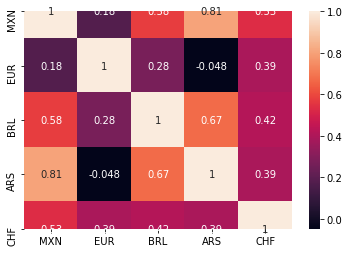

In [52]:
headmap_sb = sb.heatmap(df_data.corr(), annot=True)

## Ejercico 4

Con el DataFrame creado en el ejercicio 2, crea un nuevo DataFrame que incluya una correlación móvil con ventana de 30 días de cada una de las monedas respecto a `"MXN"`. **hint**: Investiga sobre el método `.xs` de un DataFrame

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>EUR</th>      <th>BRL</th>      <th>ARS</th>      <th>CHF</th>    </tr>  </thead>  <tbody>    <tr>      <th>2015-03-19</th>      <td>0.900941</td>      <td>0.870440</td>      <td>0.835029</td>      <td>0.916637</td>    </tr>    <tr>      <th>2015-03-20</th>      <td>0.874866</td>      <td>0.815453</td>      <td>0.762308</td>      <td>0.903594</td>    </tr>    <tr>      <th>2015-03-22</th>      <td>0.866783</td>      <td>0.789977</td>      <td>0.726098</td>      <td>0.900547</td>    </tr>    <tr>      <th>2015-03-23</th>      <td>0.835823</td>      <td>0.728781</td>      <td>0.643129</td>      <td>0.885424</td>    </tr>    <tr>      <th>2015-03-24</th>      <td>0.801267</td>      <td>0.671188</td>      <td>0.560149</td>      <td>0.877682</td>    </tr>  </tbody></table>

In [53]:
cor_mov = df_data.rolling(30).corr().dropna()
cor_mov.head()

MXN       EUR       BRL       ARS       CHF
2014-12-10 MXN  1.000000  0.687213  0.325804  0.974887  0.685253
           EUR  0.687213  1.000000  0.015035  0.619399  0.995422
           BRL  0.325804  0.015035  1.000000  0.283967 -0.010822
           ARS  0.974887  0.619399  0.283967  1.000000  0.619416
           CHF  0.685253  0.995422 -0.010822  0.619416  1.000000

In [61]:
df_2 = cor_mov.xs("MXN", level = 1)[["EUR","BRL","ARS","CHF"]]
df_2.loc["2015-03-19":].head()

,EUR,BRL,ARS,CHF
2015-03-19,0.900941,0.870440,0.835029,0.916637
2015-03-20,0.874866,0.815453,0.762308,0.903594
2015-03-22,0.866783,0.789977,0.726098,0.900547
2015-03-23,0.835823,0.728781,0.643129,0.885424
2015-03-24,0.801267,0.671188,0.560149,0.877682


## Ejercicio 5

Con el DataFrame creado en el ejercicio 4, crea la siguiente figura con _scatterplots_ entre todas las combinaciones de las correlaciones respecto a `"MXN"`. ¿Encuentras algún patrón en alguna combinación?

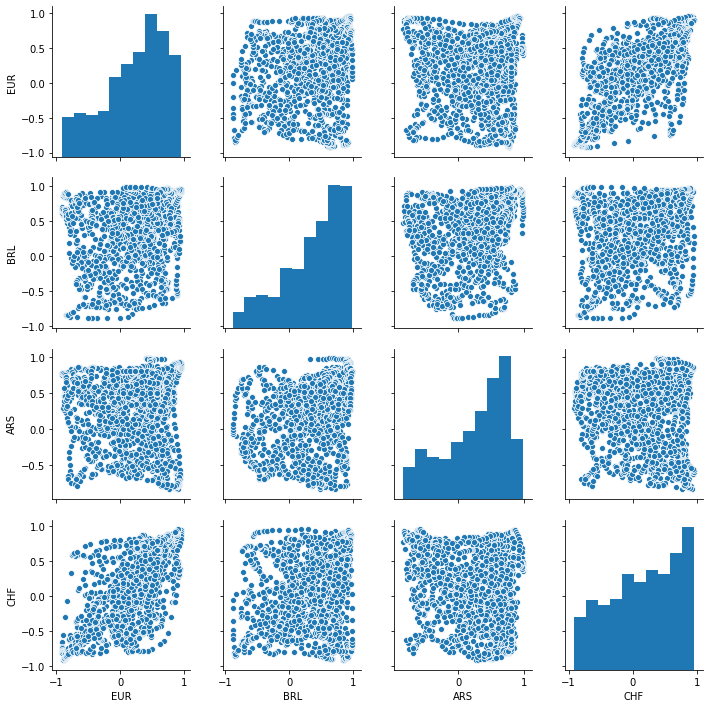

In [74]:
# sb.scatterplot(df_2,)
sb.pairplot(df_2, vars = ["EUR","BRL","ARS","CHF"])

## Ejercicio 6 

Con el DataFrame creado en el ejercicio 4, crea la siguiente figura, la cuál representa, a cada observación, la correlación promedio entre todas las monedas respecto a `"MXN"` y unas bandas que representan la correlación máxima y mínima a cada observación.

In [78]:
import matplotlib.pyplot as plt

In [ ]:
df_2['max_corr'] = df_2[['EUR', 'BRL', 'ARS', 'CHF']].max(axis = 1) 
df_2['min_corr'] = df_2[['EUR', 'BRL', 'ARS', 'CHF']].min(axis = 1) 
df_2['avg_corr'] = df_2[['EUR', 'BRL', 'ARS', 'CHF']].mean(axis = 1)

In [77]:
df_img = df_2[["max_corr","avg_corr","min_corr"]]
df_img.head()

,max_corr,avg_corr,min_corr
2014-12-10,0.974887,0.668289,0.325804
2014-12-11,0.975359,0.675065,0.444098
2014-12-12,0.976607,0.655898,0.531188
2014-12-14,0.979615,0.637848,0.485051
2014-12-15,0.981691,0.631396,0.444021


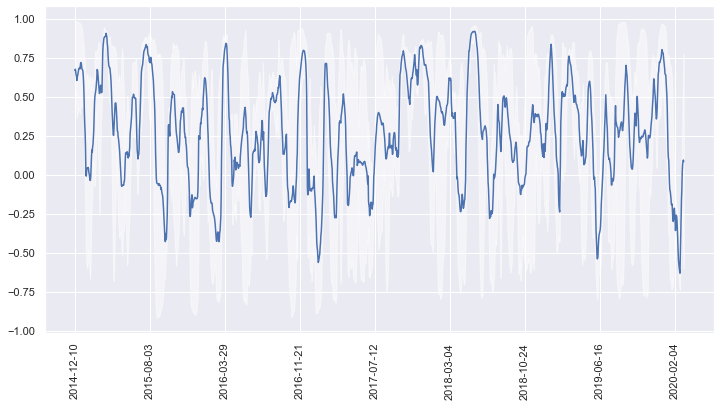

In [81]:
sb.set(rc={'figure.figsize':(12,6)})
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.tick_params(axis = "x",labelrotation=90)
ax.plot(df_img['avg_corr'])
ax.fill_between(df_img.index ,df_img['min_corr'] , df_img['max_corr'], color = "", alpha = 0.5)